In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### The below libraries are required for compatibility purposes

The code in Git repository does support higher version of TensorFlow and higher version than the below creates problem while loading the model.

In [ ]:
# # !pip install tensorflow
!pip install keras==2.3.1
!pip install tensorflow==2.2.0
!pip install 'h5py==2.10.0' --force-reinstall
!pip install scikit-image==0.16.2

In [ ]:
# !uname -r

In [2]:
import tensorflow
import keras
import skimage
import matplotlib.patches as patch

print(tensorflow.__version__)
print(keras.__version__)
print(skimage.__version__)

2.2.0
2.3.1
0.16.2


Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

!nvidia-smi

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6287935061494814032
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5978414373864396936
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17824316186938483355
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11331294244712205837
physical_device_desc: "device: XLA_GPU device"
]
Wed Apr 26 05:58:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr

## Cloning the Masked RCNN repository from github

In [ ]:
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git

## Getting access to the images and the annotations

In [4]:
image_path = "/kaggle/input/geospatial-data/images"
json_path = "/kaggle/input/geospatial-data/result.json"

In [5]:
import glob

images = glob.glob(os.path.join(image_path, "*"))
len(images)

47

In [6]:
import skimage.io
import matplotlib.pyplot as plt

# img = skimage.io.imread(images[0])
# plt.imshow(img)

In [7]:
import json

raw_labels = json.load(open(json_path, "r"))
print(raw_labels.keys())
print(raw_labels['images'][0])
# print(raw_labels['annotations'][i]['segmentation'])
# for i in range(len(raw_labels['annotations'])):
#     print(i, len(raw_labels['annotations'][i]['segmentation'][0]))

dict_keys(['images', 'categories', 'annotations', 'info'])
{'width': 1822, 'height': 868, 'id': 0, 'file_name': 'images\\0e8e3f63-14.png'}


In [8]:
def get_image_and_annotation(image_index):
    image_inst = raw_labels['images'][image_index]
    target = image_inst['file_name'].replace("\\", "/")
    image_ref = ""
    for im in images:
        if target in im:
            image_ref = im
    image_annts = []
    for annts in raw_labels['annotations']:
        if annts['image_id'] == image_inst['id']:
            image_annts.append(annts)
    return image_annts, image_ref, image_inst['id'], (image_inst['width'], image_inst['height'])


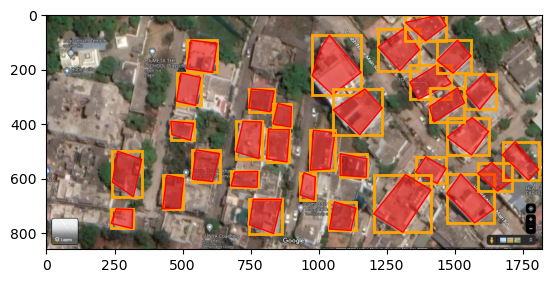

In [9]:
image_annts, image_ref, _, _ = get_image_and_annotation(6)
im1 = skimage.io.imread(image_ref)
fig, ax = plt.subplots()
ax.imshow(im1)

for antd in image_annts:
    rect = patch.Rectangle((antd['bbox'][0], antd['bbox'][1]), antd['bbox'][2], antd['bbox'][3], linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)

    mlist = antd['segmentation'][0]
    polg = [(mlist[i], mlist[i+1]) for i in range(0, len(mlist), 2)]
    rect = patch.Polygon(polg, linewidth=1, ec=(1,0,0,1), fc=(1,0,0,0.5))
    ax.add_patch(rect)
plt.show()

In [10]:
%cd Mask-RCNN-TF2

/kaggle/working/Mask-RCNN-TF2


There is an issue with keras latest version hence we need to downgrade to keras version 2.0.8


module 'keras.engine' has no attribute 'Layer'

In [11]:
import mrcnn
import mrcnn.utils
import mrcnn.config
import mrcnn.model

In [12]:
from keras.callbacks import ModelCheckpoint

In [13]:
class GeoSpatialDataset(mrcnn.utils.Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "building")
        for n in range(len(glob.glob(os.path.join(image_path, "*")))):
            image_annotation, image_filepath, image_id, image_dim = get_image_and_annotation(n)
            if is_train and int(image_id) >= 40:
                continue
            if not is_train and int(image_id) < 40:
                continue
            rectified_annotations = {
                "image_dim": image_dim,
                "annotations": image_annotation
            }
            self.add_image('dataset', image_id=image_id, path=image_filepath, annotation=rectified_annotations)
                
    
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotation']
        width, height = annotations['image_dim']
        bboxes = []
        polygons = []
#         for annots in annotations['annotations']:
#             x1 = annots['bbox'][0]
#             y1 = annots['bbox'][1]
#             x2 = x1 + annots['bbox'][2]
#             y2 = y1 + annots['bbox'][3]
#             bboxes.append([x1, y1, x2, y2])
        for annots in annotations['annotations']:
            y_annots, x_annots = [], []
            for n, val in enumerate(annots['segmentation'][0]):
                if n % 2 == 0:
                    x_annots.append(val)
                else:
                    y_annots.append(val)
            polygons.append({'x_cor': x_annots, 'y_cor': y_annots})
        
        masks = np.zeros([height, width, len(polygons)], dtype=np.uint8)
        
        class_ids = []
#         for i in range(len(bboxes)):
#             box = bboxes[i]
#             row_s, row_e = int(box[1]), int(box[3])
#             col_s, col_e = int(box[0]), int(box[2])
#             masks[row_s:row_e, col_s:col_e, i] = 1
#             class_ids.append(self.class_names.index('building'))

        for i, p in enumerate(polygons):
            rr, cc = skimage.draw.polygon(p['y_cor'], p['x_cor'])
            masks[rr, cc, i] = 1
            class_ids.append(self.class_names.index('building'))

        return masks, np.asarray(class_ids, dtype='int32')
    

In [14]:
# Train dataset
dataset_path = "/kaggle/input/geospatial-data/images/"
train_dataset = GeoSpatialDataset()
train_dataset.load_dataset(dataset_dir=dataset_path, is_train=True)
train_dataset.prepare()

In [15]:
# Validation Dataset
validation_dataset = GeoSpatialDataset()
validation_dataset.load_dataset(dataset_dir=dataset_path, is_train=False)
validation_dataset.prepare()

In [16]:
# Changing the MRCNN confiurations
class GeoSpatialConfiguration(mrcnn.config.Config):
    NAME = "GeoSpatial_cfg"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2      # Actual number of classes + 1 (for the background or non-target entries)
    LEARNING_RATE = 0.001
    STEPS_PER_EPOCH = 50

geospatial_config = GeoSpatialConfiguration()

In [17]:
# import tensorflow.compat.v1 as tf

# tf.disable_v2_behavior()

model = mrcnn.model.MaskRCNN(
    mode = 'training',
    model_dir = "./",
    config=geospatial_config
)

model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [ ]:
# # Download the pre-trained weights
import urllib.request as urlreq

urlreq.urlretrieve("https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5", "mask_rcnn_coco.h5")


In [18]:
model.load_weights(
    filepath='mask_rcnn_coco.h5',
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)
print("Weight loading done..")

Weight loading done..


In [19]:
checkpoint = ModelCheckpoint('./model_with_best_val_loss.h5', 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='auto'
)

In [21]:
model.train(
    train_dataset=train_dataset,
    val_dataset=validation_dataset,
    learning_rate=geospatial_config.LEARNING_RATE,
    epochs=10,
    layers='heads',
)


Starting at epoch 0. LR=0.001

Checkpoint Path: //logdir//train/mask_rcnn_geospatial_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistr

2023-04-26 06:50:48.139476: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-04-26 06:50:48.139549: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI could not be loaded or symbol could not be found.
2023-04-26 06:50:48.139593: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI could not be loaded or symbol could not be found.


Epoch 1/10
 1/50 [..............................] - ETA: 1:54:09 - loss: 2.1489

2023-04-26 06:53:17.341121: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-04-26 06:53:17.341227: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI could not be loaded or symbol could not be found.


 2/50 [>.............................] - ETA: 1:37:58 - loss: 2.1392

2023-04-26 06:55:02.478066: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI could not be loaded or symbol could not be found.


50/50 [==============================] - 2727s 55s/step - loss: 1.8750 - val_loss: 1.5577
Epoch 2/10
50/50 [==============================] - 2535s 51s/step - loss: 1.7183 - val_loss: 1.5784
Epoch 3/10
50/50 [==============================] - 2538s 51s/step - loss: 1.6377 - val_loss: 1.4242
Epoch 4/10
50/50 [==============================] - 2477s 50s/step - loss: 1.6484 - val_loss: 1.3824
Epoch 5/10
50/50 [==============================] - 2495s 50s/step - loss: 1.4654 - val_loss: 1.3893
Epoch 6/10
50/50 [==============================] - 2507s 50s/step - loss: 1.5119 - val_loss: 1.4556
Epoch 7/10
50/50 [==============================] - 2540s 51s/step - loss: 1.3615 - val_loss: 1.2744
Epoch 8/10
50/50 [==============================] - 2464s 49s/step - loss: 1.3382 - val_loss: 1.2412
Epoch 9/10
50/50 [==============================] - 2463s 49s/step - loss: 1.3034 - val_loss: 1.2971
Epoch 10/10
50/50 [==============================] - 2443s 49s/step - loss: 1.3080 - val_loss: 1.0138


In [ ]:
!ls

In [22]:
model_path = "./geospatial_model_26_04_2023_19_30.h5"
model.keras_model.save_weights(model_path)

### Making Predictions

In [24]:
import glob

image_samps = glob.glob(image_path+"/*")

In [35]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

class GeoSpatialTestConfig(mrcnn.config.Config):
    NAME = "geoSpatialTestConfig"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2

model = mrcnn.model.MaskRCNN(mode="inference", config=GeoSpatialTestConfig(), model_dir=None)

model.load_weights(filepath="./geospatial_model_26_04_2023_19_30.h5", by_name=True)

image = cv2.imread(image_samps[42])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result = model.detect([image], verbose=0)

result = result[0]


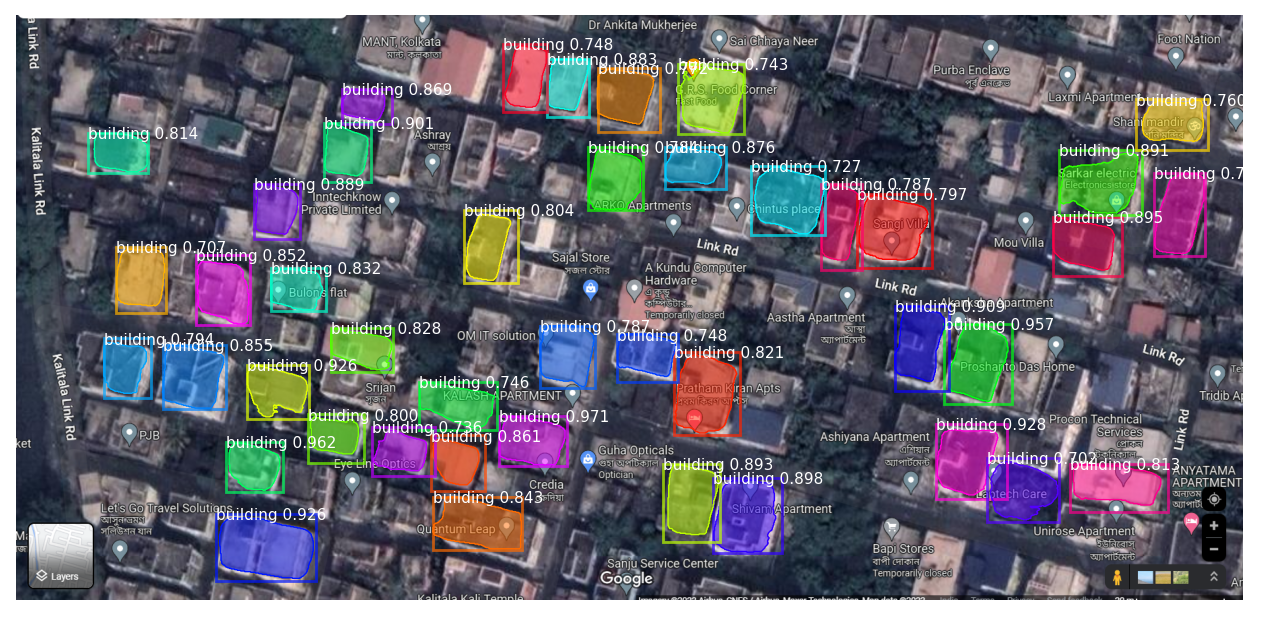

In [36]:
mrcnn.visualize.display_instances(
    image=image,
    boxes=result['rois'],
    masks=result['masks'],
    class_ids=result['class_ids'],
    class_names=['other', 'building'],
    scores=result['scores']
)